# Approximation of some analytical examples by using the Gaussian process
###### First written: December 6, 2019
###### 1st Update: December 12, 2019, add GPyTorch

In this notebook, I demonstrate the ability of the Gassian process to efficiently approximate some analytical examples that exhibit local features.

Firstly, I include numerical libraries as well as the Gaussian process package namely GPy and GPyTorch.

In [1]:
import numpy as np
import GPy
import torch
import gpytorch
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
# Use TeX font
rc('font', **{'family': 'sans-serif', 'serif': ['Helvetica']})
rc('text', usetex=True)
plt.rcParams["font.size"] = 15

np.random.seed(0)  # Fix the seed to get the same result

%matplotlib inline
%load_ext autoreload
%autoreload 2

## $f(x) = \left| 0.25 - x_{1}^{2} - x_{2}^{2}\right|$
The fist analytical example that I interpolate by the Gaussian process takes the following function:

\begin{align}
    f(x) = \left| 0.25 - x_{1}^{2} - x_{2}^{2}\right|
\end{align}

Clearly the above function has a local feature, making the approximation of this function numerically challenging especially for the grid-based approximation method with the global polynomials such as Chebyshev.

Firstly we plot the above function in the domain of $[0, 1] \times [0, 1]$:

In [2]:
def f(x):
    """ The function to be predicted """
    return np.abs(0.25 - x[:, 0]**2 - x[:, 1]**2)


def f_torch(x):
    """ The function to be predicted by GPyTprch """
    return np.abs(0.25 - x**2 - x**2)

num_test = 1000
num_input = 2
X_test_f = np.random.uniform(0., 1., (num_test, num_input))
y_true_f = f(X_test_f)

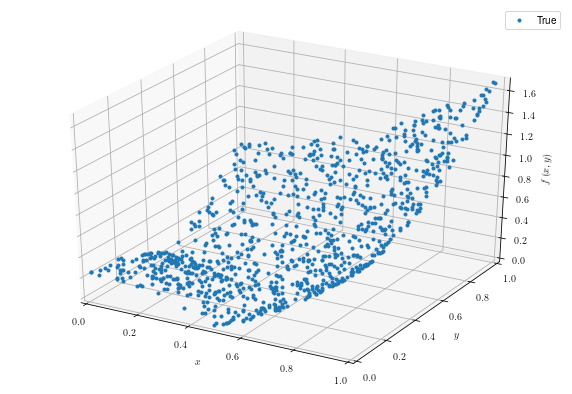

In [3]:
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.plot(X_test_f[:, 0], X_test_f[:, 1], y_true_f.ravel(), 'o', markersize=3,
        label=r'True')
ax.set_xlabel(r"$x$")
ax.set_xlim([0., 1.])
ax.set_ylabel(r"$y$")
ax.set_ylim([0., 1.])
ax.set_zlabel(r"$f\left(x, y\right)$")
ax.set_zlim([0, None])
ax.legend(loc='best')
plt.show()

We define the mean squared error (: MSE hereafter) to measure the approximation quality: 

In [4]:
def compute_mse(y_true, y_pred):
    """ Compute the mean squared error """
    return 1 / len(y_true) * np.sum(np.square(y_true - y_pred.ravel()))

### GPy
Next we instantiate and initialize the Gaussian process regression, provided by GPy, and measure MSE:

In [5]:
def return_mse(analyticFunc, X_test, Xbeg, Xend, y_true, num_trainings, num_input):
    """ Compute the mean squared error. Use the GPy library """
    mse_err = []  # Track the MSE error
    for num in num_trainings:
        # Generate training data
        X_train = np.random.uniform(Xbeg, Xend, (num, num_input))
        y_train = analyticFunc(X_train).reshape(num, 1)
        # Instantiate the Gaussian Process model
        kernel = GPy.kern.RBF(input_dim=num_input)
        gp = GPy.models.GPRegression(X_train, y_train, kernel)
        # Fit to data using Maximum Likelihood Estimation of the parameters
        gp.optimize_restarts(num_restarts=10, verbose=False)
        # Make the prediction
        y_pred, sigma = gp.predict(X_test)
        # Track the error
        mse_err.append(compute_mse(y_true, y_pred))

    return mse_err

We define the number of training datasets and compute MSE with respect to the number of training examples:

In [6]:
num_trainings_f = [10, 55, 100, 550, 1000]
mse_err_f = return_mse(f, X_test_f, 0, 1, y_true_f, num_trainings_f, num_input)

### GPyTorch

Next we use GPyTorch library to approximate the above function.

In [7]:
def return_mse_torch(
    analyticFunc_torch, Xbeg, Xend, learning_rate, training_iter, num_trainings):
    """ Compute the mean squared error. Use the GPyTorch library """
    
    mse_err = []  # Track the MSE error
    
    for num in num_trainings:
        # Generate training data        
        train_x = torch.linspace(Xbeg, Xend, num)
        train_y = analyticFunc_torch(train_x)
        
        # Instantiate the Gaussian Process model
        # RBF kernel
        class ExactGPModel(gpytorch.models.ExactGP):
            def __init__(self, trian_x, train_y, likelihood):
                super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
                self.mean_module = gpytorch.means.ConstantMean()
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

            def forward(self, x):
                mean_x = self.mean_module(x)
                covar_x = self.covar_module(x)
                return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        
        # Initialize likelihood and model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ExactGPModel(train_x, train_y, likelihood)

        # ------------------------------------------------------------------- #
        # Find optimal model hyperparameters
        # Train the model
        # ------------------------------------------------------------------- #
        model.train()
        likelihood.train()

        # Use the adam optimizer
        optimizer = torch.optim.Adam([
            # Includes GaussianLikelihood parameters
            {'params': model.parameters()}, ], lr=learning_rate)

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calculate loss and backprop gradients
            loss = - mll(output, train_y)
            loss.backward()
#             print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#                 i + 1, training_iter, loss.item(),
#                 model.covar_module.base_kernel.lengthscale.item(),
#                 model.likelihood.noise.item()
#             ))
            optimizer.step()  # Take a step on the optimizer
        
        # ------------------------------------------------------------------- #
        # Evaluate the GP model with the test samples
        # ------------------------------------------------------------------- #
        model.eval()
        likelihood.eval()

        # Test points are regularly spaced along [Xbeg, Xend]
        # Make predictions by feeding model through likelihood
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            test_x = torch.linspace(Xbeg, Xend, 1000)
            observed_pred = likelihood(model(test_x))

        # Track the mean of the prediction
        y_mean = observed_pred.mean.numpy()
        # Track the lower and the upper stndard deviations
        y_std_lower, y_std_upper = observed_pred.confidence_region()
        
        # Track the true function
        y_true = analyticFunc_torch(test_x).numpy()
        # Track the mean squared error
        mse_err.append(compute_mse(y_true, y_mean))

    return mse_err

In [8]:
num_trainings_f = [10, 55, 100, 550, 1001]
mse_err_f_torch = return_mse_torch(f_torch, 0, 1, 0.1, 250, num_trainings_f)

Finally plot MSE of this analytical example:

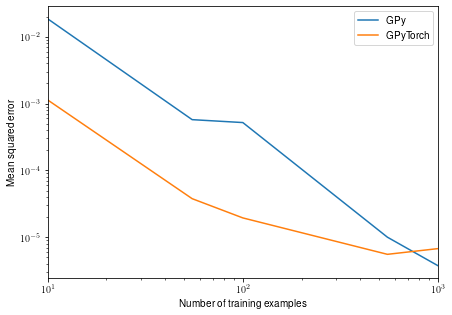

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(num_trainings_f, mse_err_f, label="GPy")
ax.plot(num_trainings_f, mse_err_f_torch, label='GPyTorch')
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Mean squared error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best')
ax.set_xlim([np.min(num_trainings_f), np.max(num_trainings_f)])
plt.show()

## $g(x) = \exp{\left(0.3 x_{1} + 0.7 x_{2}\right)}$

The next function we address is the 2-dimensional exponential function. First we plot the function on the domain of $[-1, 1] \times [-1, 1]$:

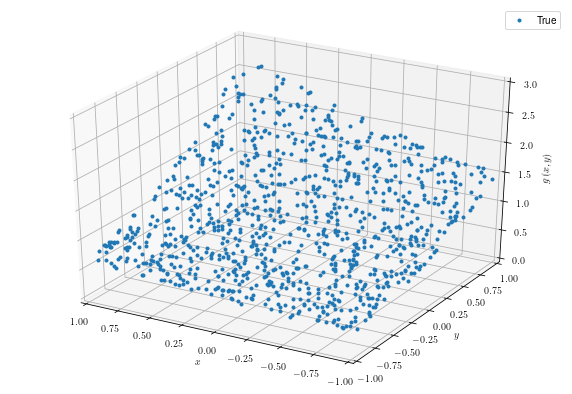

In [10]:
def g(x):
    """ The function to be predicted """
    return np.exp(0.3 * x[:, 0] + 0.7 * x[:, 1])

def g_torch(x):
    """ The function to be predicted """
    return np.exp(0.3 * x + 0.7 * x)

X_test_g = np.random.uniform([-1, -1], [1, 1], (num_test, num_input))
y_true_g = g(X_test_g)

# Plot
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.plot(X_test_g[:, 0], X_test_g[:, 1], y_true_g.ravel(), 'o', markersize=3,
        label=r'True')
ax.set_xlabel(r"$x$")
ax.set_xlim([-1., 1.])
ax.set_ylabel(r"$y$")
ax.set_ylim([-1., 1.])
ax.invert_yaxis()
ax.set_zlabel(r"$g\left(x, y\right)$")
ax.set_zlim([0., 3.])
ax.legend(loc='best')
plt.show()

### GPy
We check the sensitivity of MSE with respect to the number of training examples by using GPy.

In [11]:
num_trainings_g = [4, 8, 16, 32, 64]
mse_err_g = return_mse(
    g, X_test_g, -1, 1, y_true_g, num_trainings_g, num_input)

### GPyTorch

Next we use GPyTorch.

In [12]:
num_trainings_g = [4, 8, 16, 32, 64]
mse_err_g_torch = return_mse_torch(g_torch, -1, 1, 0.1, 250, num_trainings_g)
print(mse_err_g_torch)

[0.005273900985717774, 1.1111652478575707e-05, 5.144431255757809e-06, 3.37927183136344e-06, 2.3994268849492075e-06]


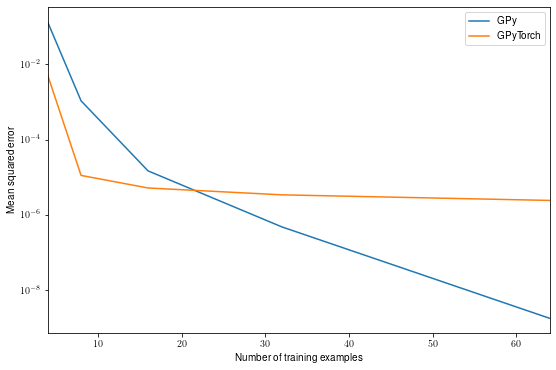

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(num_trainings_g, mse_err_g, label="GPy")
ax.plot(num_trainings_g, mse_err_g_torch, label="GPyTorch")
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.set_xlim([np.min(num_trainings_g), np.max(num_trainings_g)])
ax.legend(loc='best')
plt.show()

## $h(x) = \frac{1}{\left|0.5 - x_{1}^{4} - x_{2}^{4}\right| + 0.1}$

The last example we examine in this notebook again exhibits a local feature:

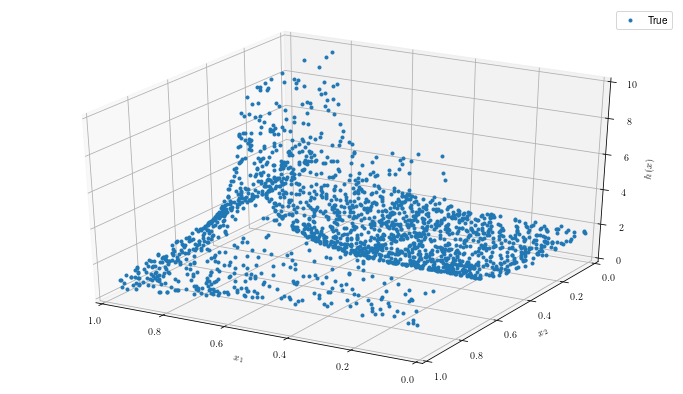

In [14]:
def h(x):
    """ The function to be predicted """
    return 1 / (np.abs(0.5 -  x[:, 0]**4 - x[:, 1]**4) + 0.1)

def h_torch(x):
    """ The function to be predicted """
    return 1 / (np.abs(0.5 -  x**4 - x**4) + 0.1)

X_test_h = np.random.uniform([0, 0], [1, 1], (2000, num_input))
y_true_h = h(X_test_h)

# Plot
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={'projection': '3d'})
ax.plot(X_test_h[:, 0], X_test_h[:, 1], y_true_h.ravel(), 'o', markersize=3,
        label=r'True')
ax.set_xlabel(r"$x_{1}$")
ax.set_xlim([1., 0.])
ax.set_ylabel(r"$x_{2}$")
ax.set_ylim([1., 0.])
ax.set_zlabel(r"$h\left(x\right)$")
ax.set_zlim([0., 10])
ax.legend(loc='best')
plt.show()

### GPy
Then check MSE when we change the number of training examples:

In [15]:
X_test_hh = np.random.uniform([0, 0], [1, 1], (num_test, num_input))
y_true_hh = h(X_test_hh)
num_trainings_h = [10, 55, 100, 550, 1000]
mse_err_h = return_mse(
    h, X_test_hh, 0, 1, y_true_hh, num_trainings_h, num_input)

### GPyTorch

We use GPyTorch to approximate the last analytical example.

In [16]:
num_trainings_h = [10, 55, 100, 550, 1001]
mse_err_h_torch = return_mse_torch(h_torch, 0, 1, 0.1, 500, num_trainings_h)

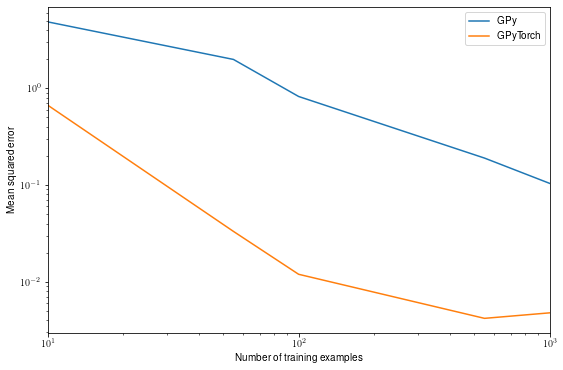

In [17]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(num_trainings_h, mse_err_h, label='GPy')
ax.plot(num_trainings_h, mse_err_h_torch, label='GPyTorch')
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Mean squared error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best')
ax.set_xlim([np.min(num_trainings_h), np.max(num_trainings_h)])
plt.show()

Unfortunately, the approximation quality is poor. We need to come up with, for instance, different kernels or the set of kernels to achieve better-fit. 

## Observations

- GPy is in general better than GPyTorch with the above hyperparameter setting.
- We need to come up with a better choice of kernels to improve an approximation quality.
- GPyTorch is more flexible than GPy. We can change the hyperprameters, optimizers etc. easily.
- GPyTorch uses optimizers from PyTorch.
- If we want to control minor parts in the Gaussian process, GPyTorch is the way to go.